# Analysis of Shock Series Data

This notebook analyzes shock series data from an Excel file, tests for normality, and creates histograms with probability density function overlays.

In [ ]:
# Install packages (uncomment and run only once if you haven't installed these packages)
#using Pkg
#Pkg.add(["XLSX", "DataFrames", "Plots", "StatsPlots", "Statistics", "Distributions", "HypothesisTests"])

In [ ]:
# Load required packages
using XLSX
using DataFrames
using Plots
using StatsPlots
using Statistics
using Distributions
using HypothesisTests

## Read and Prepare Data

Define a function to read the Excel file with specific handling for our requirements.

In [ ]:
"""
Read Excel data with specific handling requirements:
- Skip first empty row
- Use second row as column headers
- Include columns B to M, but exclude column C
- Handle "#I/T" values by treating them as missing
"""
function read_excel_series(; include_0::Bool=false, file_path="data/shockseries.xlsx")
    
    # Prep dict
    series_dfs = Dict()

    # Read the Excel file
    xlsx_file = XLSX.readxlsx(file_path)
    
    for i in 1:2
        sheet = xlsx_file[i]  
        
        # Read the entire data range including headers
        data_range = sheet[:]
        
        # Extract column headers from the second row (row index 2)
        headers = data_range[2, :]
        
        # Create a DataFrame from data, starting from row 3
        df_all = DataFrame(data_range[3:end, :], Symbol.(headers))
        
        # Identify columns to keep (B to M, excluding C in sheet 1)
        # Column A contains dates (index 1) C is missing in sheet 1
        if i == 1
            keep_cols = [2, 4:13...]  # Columns C is missing in sheet 1
        else
            keep_cols = [2:13...] 
        end

        # Extract only the columns we want
        df_filtered = df_all[:, keep_cols]

        for col in names(df_filtered)
            # Create a new dataframe for this series
            series_df = DataFrame()
            
            # Copy column values with proper handling of problematic values
            series_df[!, :value] = map(df_filtered[!, col]) do val
                if val isa String && (val == "#I/T" || val == "" || val == "NA")
                    return missing
                elseif val isa Missing
                    return missing
                elseif (val == 0 || val == "0" || val == "0.0") && include_0 == false
                    return missing
                else
                    # Try to convert to Float64, if it fails return missing
                    try
                        return parse(Float64, string(val))
                    catch
                        return missing
                    end
                end
            end
            
            # Remove rows with missing values
            series_df = dropmissing(series_df)
            
            # Store this processed series
            series_dfs[string(col)] = series_df
        end
    end

    return series_dfs
end;

In [ ]:
series_dict = read_excel_series(include_0 = false);

## Basic Statistics

Calculate and display basic statistics for each series.

In [ ]:
"""
Generate basic statistics for a data series
"""
function print_statistics(series_value, series_name)
    data = series_value
    println("\n==== Basic Statistics for '$series_name' ====")
    println("Count: $(length(data))")
    println("Min: $(minimum(data))")
    println("Max: $(maximum(data))")
    println("Mean: $(mean(data))")
    println("Median: $(median(data))")
    println("Standard Deviation: $(std(data))")
end;

In [ ]:
basic_stats = Dict()

for (key, _) in series_dict
    basic_stats[key] = print_statistics(series_dict["$key"].value, key)
end;

## Normality Testing

Test each series for normality using Shapiro-Wilk and Kolmogorov-Smirnov tests.

In [ ]:
"""
Test if a data series follows a normal distribution
"""
function test_normality(series_value, series_name)
    data = series_value
    #println("\n==== Normality Tests for '$series_name' ====")
    
    # Shapiro-Wilk test
    sw_test = ShapiroWilkTest(data)
    
    # Kolmogorov-Smirnov test
    μ = mean(data)
    σ = std(data)
    ks_test = ExactOneSampleKSTest(data, Normal(μ, σ))
    
    # Print results
    #println("Shapiro-Wilk Test:")
    #println("W = $(sw_test.W), p-value = $(pvalue(sw_test))")
    #println("$(pvalue(sw_test) < 0.05 ? "Reject" : "Fail to reject") null hypothesis of normality at 5% significance level")
    
    #println("\nKolmogorov-Smirnov Test:")
    #println("D = $(ks_test.δ), p-value = $(pvalue(ks_test))")
    #println("$(pvalue(ks_test) < 0.05 ? "Reject" : "Fail to reject") null hypothesis of normality at 5% significance level")
    
    # Print skewness and kurtosis
    skew = skewness(data)
    kurt = kurtosis(data)
    #println("\nSkewness: $(round(skew, digits=3)) (0 for normal distribution)")
    #println("Excess Kurtosis: $(round(kurt, digits=3)) (0 for normal distribution)")
    
    return (shapiro_wilk=sw_test, kolmogorov_smirnov=ks_test, mean = μ, std = σ, skewness=skew, kurtosis=kurt)
end

In [ ]:
test_results = Dict()

for (key, _) in series_dict
    test_results[key] = test_normality(series_dict["$key"].value, key)
end;

## Visualization

Create histograms with normal PDF overlays for each series.

In [ ]:
"""
Create histogram with PDF overlay for a data series
"""
function plot_histogram_with_pdf(data; title="Distribution Analysis")

    # Create histogram
    h = histogram(data, 
                 normalize=true,
                 alpha=0.6,
                 label="Histogram", 
                 title=title,
                 xlabel="Value", 
                 ylabel="Density")
    
    # Add kernel density estimate
    density!(h, data, label="KDE", line=(:black, 2), legend=:topright)
    
    return h
end;

In [ ]:
# Create individual plots for each series
individual_plots = Dict()

for (series_name, _) in series_dict
    individual_plots[series_name] = plot_histogram_with_pdf(
        series_dict["$series_name"].value, 
        title="Distribution of $series_name"
    )
    #display(individual_plots[series_name])
end

In [ ]:
# Convert the dictionary values to an array first
all_plots_array = collect(values(individual_plots))

# First combined figure with 12 plots
final_plot1 = plot(all_plots_array[1:12]..., 
                  layout=(4, 3), 
                  size=(1200, 900), 
                  margin=5Plots.mm)

# Display the first combined plot
display(final_plot1)

# Save the first combined plot
savefig(final_plot1, "figs/combined_series_distributions_1.png")

# Second combined figure with the remaining 11 plots
final_plot2 = plot(all_plots_array[13:23]..., 
                  layout=(4, 3),  # This will have one empty spot
                  size=(1200, 900), 
                  margin=5Plots.mm)

# Display the second combined plot
display(final_plot2)

# Save the second combined plot
savefig(final_plot2, "figs/combined_series_distributions_2.png");

## Summary of Normality Tests

Create a summary table with all normality test results.

In [ ]:
# Create a summary table
normality_summary = DataFrame(
    Series = String[],
    SW_Statistic = Float64[],
    SW_PValue = Float64[],
    KS_Statistic = Float64[],
    KS_PValue = Float64[],
    Mean = Float64[],
    Std = Float64[],
    Skewness = Float64[],
    Kurtosis = Float64[],
    Is_Normal = String[]
)

for (series_name, series_df) in series_dict
    result = test_results[series_name]
    is_normal = (pvalue(result.shapiro_wilk) > 0.05 && 
                 pvalue(result.kolmogorov_smirnov) > 0.05) ? "Yes" : "No"
    
    push!(normality_summary, (
        series_name,
        result.shapiro_wilk.W,
        pvalue(result.shapiro_wilk),
        result.kolmogorov_smirnov.δ,
        pvalue(result.kolmogorov_smirnov),
        result.mean,
        result.std,
        result.skewness,
        result.kurtosis,
        is_normal
    ))
end

# Display the summary table
normality_summary

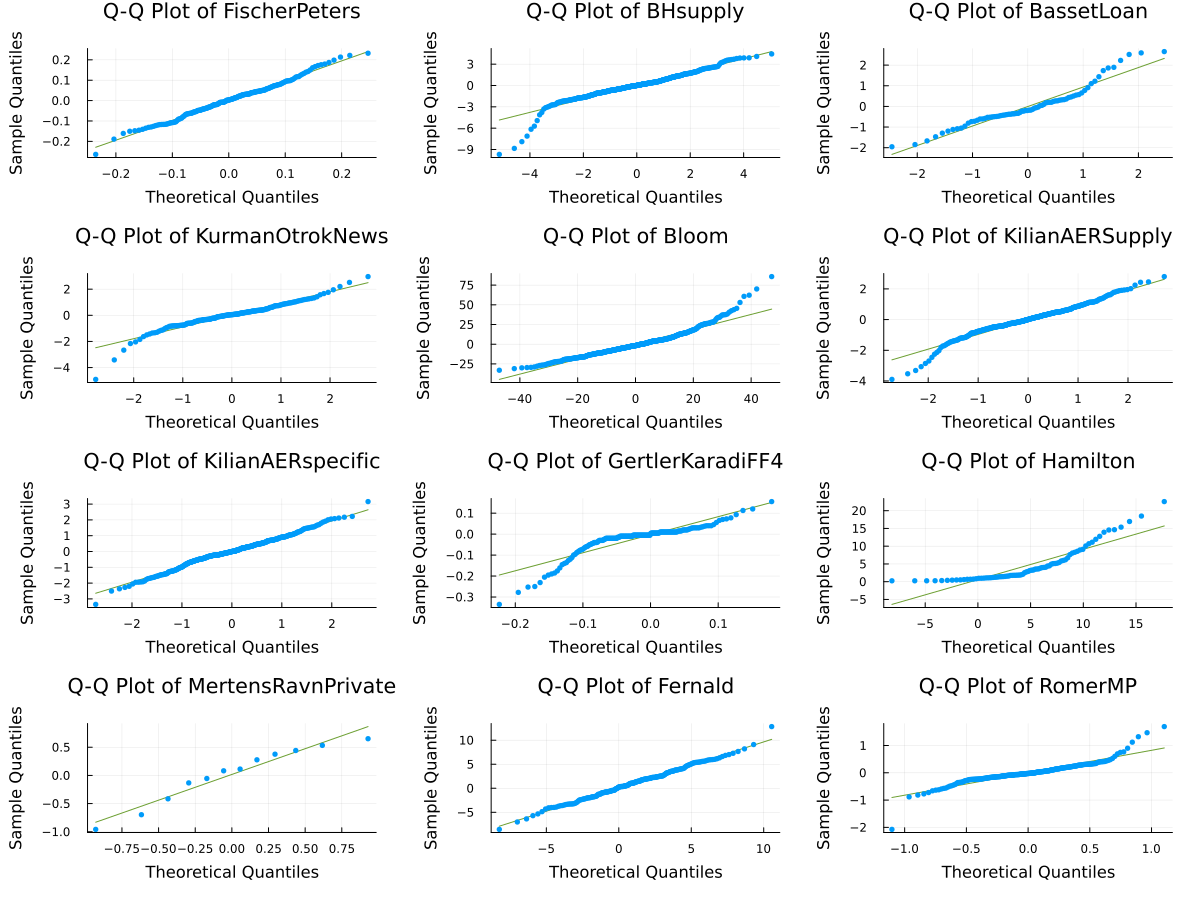

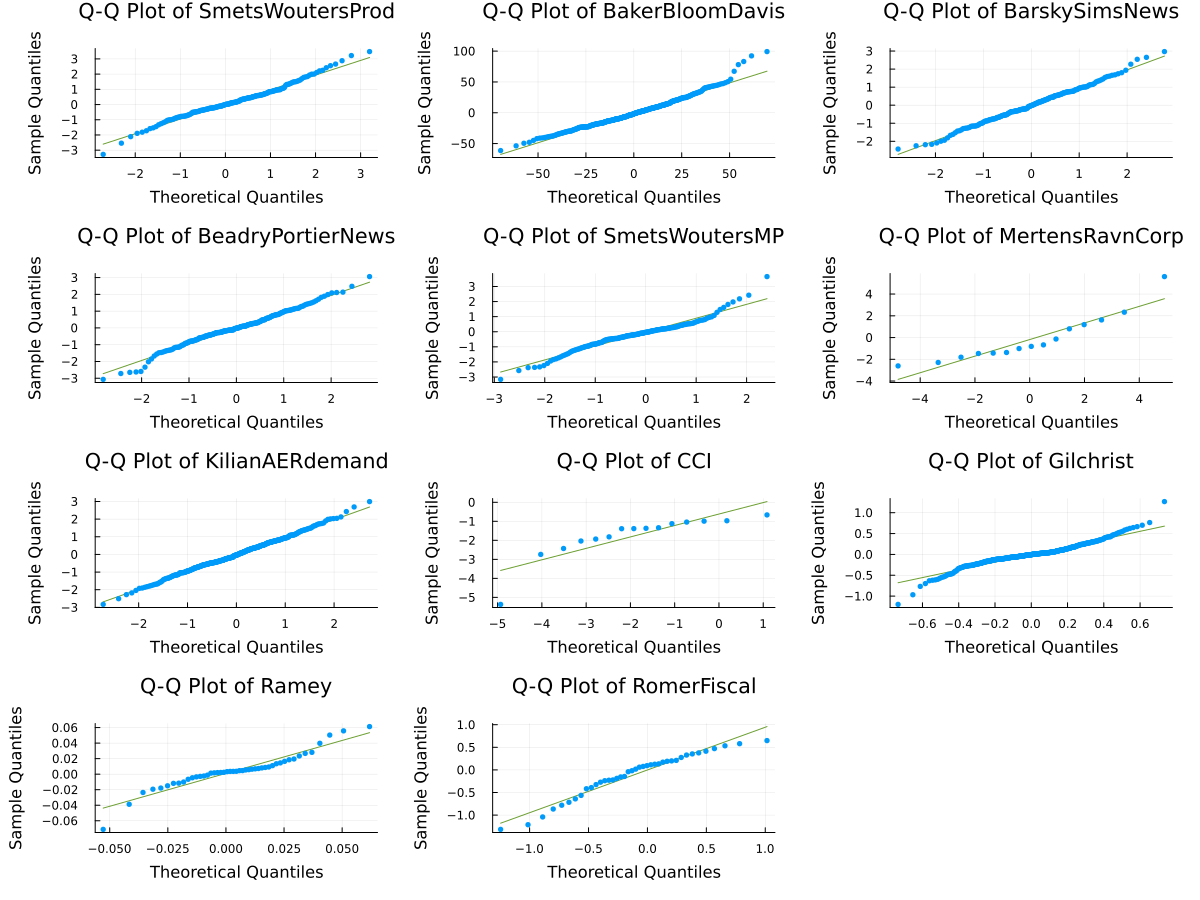

"g:\\dansk\\cjw\\analyser\\ABC\\State-Space-Model-Estimation\\Distribution of shocks\\figs\\combined_series_qq_plots_2.png"

In [44]:
"""
Create a Q-Q plot comparing a data series with a normal distribution
"""
function plot_qqplot(data, title="Q-Q Plot"; mean_val=nothing, std_val=nothing)
    # If mean and std are not provided, calculate them from the data
    if isnothing(mean_val) || isnothing(std_val)
        mean_val = mean(data)
        std_val = std(data)
    end
    
    # Create Q-Q plot against normal distribution
    qqplot = qqnorm(data, 
                   qqline=:fit,  # Add reference line
                   title=title,
                   xlabel="Theoretical Quantiles",
                   ylabel="Sample Quantiles",
                   legend=false,
                   markersize=3,
                   markerstrokewidth=0)
    
    return qqplot
end

# Create individual Q-Q plots for each series
qq_plots = Dict()

for (series_name, _) in series_dict
    # Get the mean and std from test_results
    mean_val = test_results["$series_name"].mean
    std_val = test_results["$series_name"].std
    
    # Create the Q-Q plot
    qq_plots[series_name] = plot_qqplot(
        series_dict["$series_name"].value, 
        "Q-Q Plot of $series_name",
        mean_val=mean_val,
        std_val=std_val
    )
end

# Convert the dictionary values to an array
all_qq_plots_array = collect(values(qq_plots))

# First combined figure with 12 plots
qq_final_plot1 = plot(all_qq_plots_array[1:12]..., 
                    layout=(4, 3), 
                    size=(1200, 900), 
                    margin=5Plots.mm)

# Display the first combined plot
display(qq_final_plot1)

# Save the first combined plot
savefig(qq_final_plot1, "figs/combined_series_qq_plots_1.png")

# Second combined figure with the remaining 11 plots
qq_final_plot2 = plot(all_qq_plots_array[13:23]..., 
                    layout=(4, 3),  # This will have one empty spot
                    size=(1200, 900), 
                    margin=5Plots.mm)

# Display the second combined plot
display(qq_final_plot2)

# Save the second combined plot
savefig(qq_final_plot2, "figs/combined_series_qq_plots_2.png")